<a href="https://colab.research.google.com/github/bchenley/TorchTimeSeries/blob/main/notebooks/StockPrediction_example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone TorchTimeSeries repo and go to directory:

In [1]:
!git clone https://github.com/bchenley/TorchTimeSeries.git

Cloning into 'TorchTimeSeries'...
remote: Enumerating objects: 1282, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 1282 (delta 69), reused 0 (delta 0), pack-reused 1175
Receiving objects: 100% (1282/1282), 12.93 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (852/852), done.


In [2]:
%cd /content/TorchTimeSeries

/content/TorchTimeSeries


Install PyTorch

In [3]:
!pip install torch --quiet
!pip install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 45.5 MB/s eta 0:00:00


import TorchTimeSeries modules and Finance submodules

In [4]:
from src import *
from Finance import *

Initializing TorchTimeSeries package...
Done
Initializing TorchTimeSeries package...
Initializing TorchTimeSeries package...
Done
Done


Import dependencies.

In [5]:
import torch
import pytorch_lightning as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

Construct sequence-to-sequence model to predict 6 hourly stock prices

In [6]:
input_len = [6*20]
output_len = [6]

encoder = SequenceModel(num_inputs = 1, num_outputs = 1,
                        input_size = [1], output_size = [0],
                        base_hidden_size = [64], base_rnn_bias = [True],
                        base_type = ['gru'], base_seq_type = ['encoder'], base_seq_len = input_len,
                        base_num_layers = [1],
                        base_transformer_feedforward_activation = ['relu'],
                        base_transformer_feedforward_degree = [3],
                        base_transformer_dim_feedforward = [128])

decoder = SequenceModel(num_inputs = 1, num_outputs = 1,
                        input_size = [1], output_size = [1], encoder_output_size = 64,
                        base_hidden_size = [64], base_rnn_bias = [True],
                        base_type = ['gru'], base_seq_type = ['decoder'], base_seq_len = output_len,
                        base_num_layers = [1],
                        base_rnn_attn = [True],
                        base_transformer_dim_feedforward = [128])

model = Seq2SeqModel(encoder = encoder,
                     decoder = decoder,
                     learn_decoder_init_input = False,
                     learn_decoder_hiddens = False)

print(model)

Seq2SeqModel(
  (encoder): seq_base.0.base.weight_ih_l0: shape = torch.Size([192, 1]). 192 parameters. Trainable
  seq_base.0.base.weight_hh_l0: shape = torch.Size([192, 64]). 12288 parameters. Trainable
  seq_base.0.base.bias_ih_l0: shape = torch.Size([192]). 192 parameters. Trainable
  seq_base.0.base.bias_hh_l0: shape = torch.Size([192]). 192 parameters. Trainable
  -------------------------------------
  12864 total parameters.
  12864 total trainable parameters.
  (decoder): seq_base.0.base.weight_ih_l0: shape = torch.Size([192, 1]). 192 parameters. Trainable
  seq_base.0.base.weight_hh_l0: shape = torch.Size([192, 64]). 12288 parameters. Trainable
  seq_base.0.base.bias_ih_l0: shape = torch.Size([192]). 192 parameters. Trainable
  seq_base.0.base.bias_hh_l0: shape = torch.Size([192]). 192 parameters. Trainable
  seq_base.0.attn_mechanism.in_proj_weight: shape = torch.Size([192, 64]). 12288 parameters. Trainable
  seq_base.0.attn_mechanism.in_proj_bias: shape = torch.Size([192]). 

Create datamodule.

In [7]:
input_names = ['AMZN_adj_close'] # , 'AMZN_adj_close_dv5'] # 'GOOGL_adj_close', 'GOOGL_adj_close_hv1',
output_names = input_names

end_date = datetime.now() # df_polygon['date'].max() # "2021-03-26" # datetime.now()
start_date = '2022-01-03' # end_date - timedelta(days = 365) # int(0.5*365)

stock_datamodule = StockDataModule(source = 'yfinance',
                                   apiKey = None,
                                   input_names = input_names, output_names = output_names,
                                   datetime_unit = 'h', date_format = "%Y-%m-%d",
                                   parsing = 'hour', interval = '1h',
                                   combine_stock_features = True,
                                   start_date = start_date,
                                   end_date = end_date,
                                   log_prices = False,
                                   transforms = {'all': FeatureTransform('minmax', minmax = [0, 1])},
                                   pct_train_val_test = [0.75, 0.15, 0.15],
                                   train_val_test_periods = [['2022-01-03', '2022-12-30'],
                                                             ['2023-01-02', '2023-05-31'],
                                                             ['2023-06-01', '2023-06-16']],
                                   batch_size = 128,
                                   input_len = input_len, output_len = output_len,
                                   shift = [5], stride = 1,
                                   pad_data = True,
                                   print_summary = True,
                                   device = 'cpu', dtype = torch.float32)


Define Lightning module.

In [8]:
loss_fn = Loss('mse', dims = (0, 1))
metric_fn = Loss('mape', dims = (0, 1))

opt = torch.optim.Adam(params = model.parameters(), betas = [0.9, 0.999], lr = 0.001)

stock_module = StockModule(model = model,
                           opt = opt, loss_fn = loss_fn, metric_fn=metric_fn,
                           constrain = False, penalize = False,
                           track = True,
                           model_dir = "/content")

Define baseline model for comparison with Seq2Seq model.

In [9]:
moving_average_6 = BaselineModel(model_type = 'moving_average',
                                 ma_window_size = 6)

Fit model.

In [10]:
callbacks = [pl.callbacks.EarlyStopping(monitor = 'val_epoch_loss',
                                        patience = 50,
                                        verbose = False,
                                        min_delta = 1e-3,
                                        mode = 'min')]

stock_module.fit(datamodule = stock_datamodule,
                 max_epochs = 10,
                 callbacks = None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/content/TorchTimeSeries/Finance/load_yfinance.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['date'] = pd.to_datetime(date_df['date'])
/content/TorchTimeSeries/Finance/StockDataModule.py:125: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data = {self.date_name: pd.to_datetime(df[self.date_name]).dt.to_period(self.datetime_unit).dt.to_timestamp().values}
INFO:pytorch_light

Sanity Checking: 0it [00:00, ?it/s]

Data length: 833
Window size: 125
Step indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
Input indices for AMZN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Generate predictions for training, validation, and test set.

In [11]:
stock_module.hiddens = None
stock_module.predict(baseline_model = moving_average_6)

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Data length: 196
Window size: 125
Step indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
Input indices for AMZN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 1

Predicting: 0it [00:00, ?it/s]

Plot results.

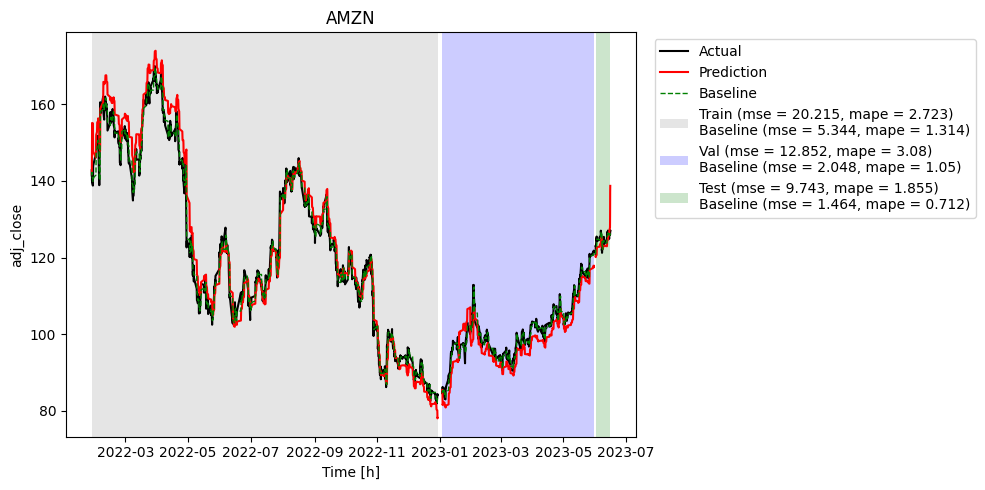

In [13]:
stock_module.plot_predictions(include_baseline = True)